In [2]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from scipy.signal import savgol_filter
import os

import sys
sys.path.append("../utility_functions/")
from objectProperties import ObjectProperties
from readExtrapolatedSpectra import ReadExtrapolatedSpectra

sys.path.append("../../Filter_Curves/")
from readBands import ReadBands

sys.path.append("../../spec_modeling/")
from model_W0116_spec import model_W0116_spec

In [3]:
#Use the latex font when plotting. 
matplotlib.rcParams['mathtext.fontset'] = 'stix'
matplotlib.rcParams['font.family'] = 'STIXGeneral'

In [4]:
#Load the properties of the BHDs
wid = "W0116-0505"
op = ObjectProperties([wid])

In [5]:
#Load the bands.
bands = ReadBands()
for bname in bands.bandnames:
    print(bname, bands.bp[bname].barlam(), bands.bp[bname].fwhm(), bands.bp[bname].rectwidth())

R_SPECIAL 6501.229535920617 Angstrom 1159.881393925198 Angstrom 1624.9974574790472 Angstrom
I_BESS 7925.773360798338 Angstrom 1080.5202412457434 Angstrom 1433.1539789444323 Angstrom
v_HIGH 5531.691038305597 Angstrom 850.6231300284223 Angstrom 1195.0838113345558 Angstrom


In [6]:
latex_band_name = {
    "v_HIGH"    : r'$v_{\rm High}$',
    "R_SPECIAL" : r'$R_{\rm Special}$',
    "I_BESS"    : r'$I_{\rm Bessel}$',
}

In [7]:
#Load the spectra for each BHD, extended using the best-fit SED.
specs = ReadExtrapolatedSpectra()

Wavelength range for object W0019-1046 limited because of sky template
Spec-range: 3001.5 Angstrom - 5423.93 Angstrom
Sky-range: 3199.4 Angstrom - 6724.06 Angstrom
Wavelength range for object W0204-0506 limited because of sky template
Spec-range: 3786.2 Angstrom - 6672.70 Angstrom
Sky-range: 3789.3 Angstrom - 6682.76 Angstrom
Warning, 2 of 3161 bins contained negative fluxes; they have been set to zero.
Wavelength range for object W0831+0140 limited because of sky template
Spec-range: 3786.2 Angstrom - 6672.45 Angstrom
Sky-range: 3789.3 Angstrom - 6682.76 Angstrom
Warning, 2 of 3161 bins contained negative fluxes; they have been set to zero.


In [8]:
op.filters

{'W0116-0505': ['R_SPECIAL', 'I_BESS', 'v_HIGH']}

In [9]:
#Load the spectrum and model. 
spec, spec_model = model_W0116_spec(specs)

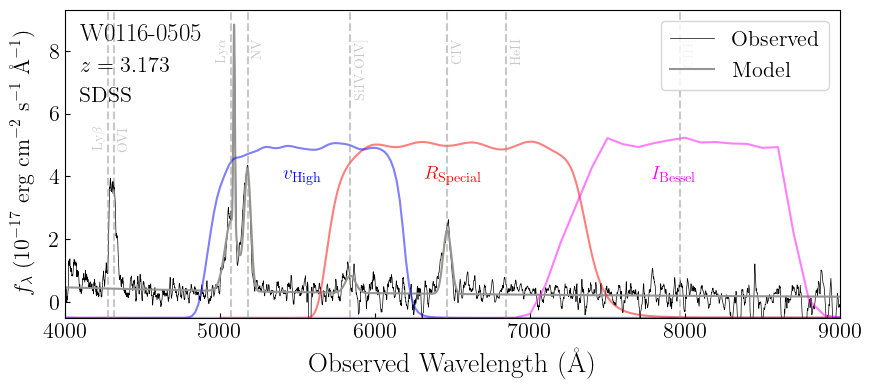

In [13]:
ymin = {"W0116-0505": -0.5}
ymax = {"W0116-0505":  9.3}

fig, ax = plt.subplots(1, figsize=(10,4), sharex=True)

ax.tick_params(direction='in', labelsize=16)#, width=2, length=6)

#First, plot the spectrum using smoothing from a savgol filter. 
flam_use = savgol_filter(specs.specs.sp[wid].flam, 21, 3)
ax.plot(specs.specs.sp[wid].lam_obs, flam_use*1e17, color='black', lw=0.5, label='Observed')

#Now, plot the model. 
ax.plot(spec.lam_obs, spec_model.flam_model(spec.lam_rest)*1e17, color='xkcd:grey', label='Model')

# #Now, plot the extension based on the best-fit SED model.
# cond = specs.lam_obs[wid] > np.max(specs.specs.sp[wid].lam_obs)
# ax.plot(specs.lam_obs[wid][cond], specs.flam[wid][cond]*1e17, color='xkcd:grey', ls='dotted')

#Plot the filters. 
trans = matplotlib.transforms.blended_transform_factory(ax.transData, ax.transAxes)
for filt in op.filters[wid]:
        if filt=='v_HIGH':
            norm = 1./100.
            color = "blue"
        else:
            norm = 1.
            if filt=='R_SPECIAL':
                    color='red'
            else:
                    color='magenta'
        ax.plot(bands.bp[filt].model.points[0], bands.bp[filt].model.lookup_table*norm*0.6, color=color, transform=trans, alpha=0.5)
        ax.text(bands.bp[filt].barlam().value, 0.45, latex_band_name[filt], transform=trans, ha='center', fontsize=14, color=color)

ax.set_ylim([ymin[wid],ymax[wid]])
ax.set_xlim([4000., 9000.])
#ax.set_xlim([3000., 10000.])

ax.text(0.02, 0.90, wid, ha='left', fontsize=18, transform=ax.transAxes)
ax.text(0.02, 0.80, r'$z={:.3f}$'.format(op.z[wid]), ha='left', fontsize=16, transform=ax.transAxes)
ax.text(0.02, 0.70, specs.specs.sp[wid].instrument, ha='left', fontsize=16, transform=ax.transAxes)

#Plot some common emission lines. 
waves_ems = {r"Ly$\beta$":1025.722, "OVI":1033.82, r"Ly$\alpha$":1215.670, "NV":1240.81, "SiIV-OIV]":1399.80, "CIV":1549.48, "HeII":1640.40, "CIII]":1908.734}
offset = {r"Ly$\beta$":-0.02, "OVI":0.005, r"Ly$\alpha$":-0.02, "NV":0.005, "SiIV-OIV]":0.005, "CIV":0.005, "HeII":0.005, "CIII]":0.005}
for line_name in waves_ems.keys():
    lam_line = waves_ems[line_name]*(1+op.z[wid])
    if wid=="W0204-0506":
        if lam_line < 4000.:
            continue
    if np.min(specs.lam_obs[wid].value)> lam_line or np.max(specs.specs.sp[wid].lam_obs.value)<lam_line:
        continue
    ax.plot([lam_line]*2, ax.get_ylim(), color='xkcd:grey', linestyle='dashed', alpha=0.5)
    yfact = 0.9
    if line_name==r"Ly$\beta$" or line_name=="OVI":
         yfact = 0.6
    ax.text(lam_line+offset[line_name]*(ax.get_xlim()[1]-ax.get_xlim()[0]), yfact*ax.get_ylim()[1], line_name, color='xkcd:grey', alpha=0.5, rotation="vertical", va='top')

#plt.subplots_adjust(wspace=0.0,hspace=0.0)
fig.supylabel(r'$f_{\lambda}~(10^{-17}~\rm erg~\rm cm^{-2}~\rm s^{-1}~\rm \AA^{-1})$', fontsize=16, x=0.07)
ax.set_xlabel(r'Observed Wavelength $(\rm \AA)$', fontsize=20)#, y=0.035)

ax.legend(fontsize=16, loc='upper right')

plt.show()

fig.savefig("W0116_spec.png", dpi=200, bbox_inches='tight')